# Sensitivity Analysis of the Silver Carp Meta IPM

## Imports and Load Data

In [1]:
import pandas as pd
import numpy as np
import sys, os
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from MetaIPM import network
from MetaIPM import populated_network
from MetaIPM import stochastic_wrapper as sw
from MetaIPM import summarize_outputs as so
from MetaIPM import recruitment
data_file_path = "./ModelData/"
import matplotlib as mpl
import cycler

graphics = "./Graphics/"

In [2]:
network_file = "network.csv"
transition_probs = "psi.csv"
transition_key = "psi_key.csv"
node_file = "node.csv"
group_file = "group_details.csv"
lw_file = "LW_Pool.csv"
vonB_file = "vonB.csv"
vonB_sigma_file = "vonB_sigma.csv"
maturity_file = "maturity.csv"

In [3]:
network_data = pd.read_csv(data_file_path + network_file)
transition_data = pd.read_csv(data_file_path  + transition_probs)
transition_key_data = pd.read_csv(data_file_path  + transition_key)
node_data = pd.read_csv(data_file_path + node_file)
group_data = pd.read_csv(data_file_path + group_file)
lw_data = pd.read_csv(data_file_path + lw_file)
vonB_data = pd.read_csv(data_file_path + vonB_file)
vonB_sigma_data = pd.read_csv(data_file_path + vonB_sigma_file)
maturity_data = pd.read_csv(data_file_path + maturity_file)

## Utility Functions for Creating and Running Models

In [4]:
def make_model():
    '''
    Creates a model using the global parameter dataframes.
    
    Returns:
    (populated_network): A network representing the model described in the global parameter dataframes
    '''
    deterministic_model = populated_network.populate_network_from_csv(
        network_data = network_data,
        transition_data = transition_data,
        transition_key_data = transition_key_data,
        node_data = node_data,
        group_data = group_data,
        lw_data = lw_data,
        vonB_data = vonB_data,
        vonB_sigma_data = vonB_sigma_data,
        maturity_data = maturity_data,
        stochastic_spawn = False,
        stochastic_pars = False
        ).show_network()
    return deterministic_model

In [5]:
def extract_population(model):
    '''
    Extracts the populations counts for each year and node from a model
    
    Parameters:
    model (populated_network): Network to extract population counts from
    
    Returns:
    (DataFrame): Table containing year, population, and node.
    '''
    out_all = so.extract_all_populations(model)
    out_all = out_all[out_all["Year"] < out_all["Year"].max()]

    out_by_node = out_all.groupby(['Year','Month','Node'])[['Population']].sum().reset_index()
    out_by_node["Months"] = out_by_node["Month"] + out_by_node["Year"]
    out_by_node = out_by_node[out_by_node["Month"] == 0]
    out_by_node['Years'] = out_by_node['Months']
    
    return out_by_node[['Years', 'Population', 'Node']]

## Sensitivity Analysis Test Function

In [6]:
def run_with_parameter(frame, col, row, value):
    '''
    Creates and runs a model with a modified parameter values.

    Parameters:
    frame (DataFrame): The dataframe where the parameter is stored.
    col (str):         The column containing the parameter.
    row (int):         The row containing the parameter.
    value (int):       The value to assign to the parameter.
    
    Returns:
    (DataFrame): A dataframe where each row represents the population distribution for each group in each population for every year.
    '''
    
    init = frame.loc[row, col]
    frame.loc[row, col] = value
    model = make_model()
    model.project_network()
    frame.loc[row, col] = init
    
    return extract_population(model)

In [7]:
def calculate_sensitivity(frame, col, row, value, delta):
    '''
    Calculates the sensitivity of a parameter at the specified value 
    for each year the model is run.
    Sensitivity is defined as the derivative of the growth rate with
    respect to the parameter. The derivative is calculated 
    using the central differenences method.
    
    Parameters:
    frame (DataFrame): The dataframe where the parameter is stored.
    col (str):         The column containing the parameter.
    row (int):         The row containing the parameter.
    value (int):       The value to assign to the parameter.
    delta (float):     Percent change to be used when calculating sensitivity.
    
    Returns:
    (int): The sensitivity of the specified parameter at the specified value.
    '''
    
    # Calculate with lower parameter
    ## Run model with lower parameter
    lower = run_with_parameter(frame, col, row, value*(1-delta))
    ## Calculate total yearly population for each pool
    l_a = (lower[lower['Node'] == 'a'])['Population']
    l_a = l_a[1:].values / l_a[:-1].values
    l_b = (lower[lower['Node'] == 'b'])['Population']
    l_b = l_b[1:].values / l_b[:-1].values

    no_change = run_with_parameter(frame, col, row, value)
    ## Calculate total yearly population for each pool
    n_a = (no_change[no_change['Node'] == 'a'])['Population']
    n_a = n_a[1:].values / n_a[:-1].values
    n_b = (no_change[no_change['Node'] == 'b'])['Population']
    n_b = n_b[1:].values / n_b[:-1].values
    
    # Calculate with upper parameter
    ## Run model with upper parameter
    upper = run_with_parameter(frame, col, row, value*(1+delta))
    u_a = (upper[upper['Node'] == 'a'])['Population']
    u_a = u_a[1:].values / u_a[:-1].values
    u_b = (upper[upper['Node'] == 'b'])['Population']
    u_b = u_b[1:].values / u_b[:-1].values 
    
    # Calculate sensitivities
    S_a = (u_a - l_a)/(2*delta*value)
    S_b = (u_b - l_b)/(2*delta*value)
    
    return S_a, S_b, l_a, l_b, n_a, n_b, u_a, u_b

In [8]:
def calculate_sensitivities(frame, col, row, values, delta):
    sens_a = []
    sens_b = []
    for value in values:
        S_a, S_b, _, _, _, _, _, _ = calculate_sensitivity(frame, col, row, value, delta)
        sens_a.append(S_a)
        sens_b.append(S_b)
    return sens_a, sens_b

In [9]:
def graph_results(sens_a, sens_b, param, values, start_at=0, filename=None):
    # Set up colormap
    n = len(sens_a)
    color = plt.cm.viridis(np.linspace(0.1,0.9,n)) # This returns RGBA; convert:
    mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
    plt.style.use('seaborn-whitegrid')
    
    # Set up subplots
    fig, axs = plt.subplots(1, 2, sharey=True,
                           subplot_kw={'box_aspect':1},
                           gridspec_kw={'wspace':0.05})
    
    
    # Plot nodes
    ## La Grange
    plt.sca(axs[0])
    for i in range(len(sens_a)):
        S_a = sens_a[i]
        plt.plot(range(start_at, len(S_a)), S_a[start_at:], label=values[i])
    plt.title('La Grange', fontsize=15)
    plt.xlabel('Years', fontsize=15)
    plt.ylabel(r'Sensitivity of $\lambda$', fontsize=15)
    
    
    ## Peoria
    plt.sca(axs[1])
    for S_b in sens_b:
        plt.plot(range(start_at, len(S_b)), S_b[start_at:])
    plt.title('Peoria', fontsize=15)
    plt.xlabel('Years', fontsize=15)
    axs[1].label_outer()
    
    plt.subplots_adjust(top=1, right=0.8)
    fig.legend(frameon=True, loc='center right', title=param)
    if filename != None:
        plt.savefig(f'{graphics}/{filename}.svg', bbox_inches='tight')
    
    plt.show()

# Sensitivitiy Graphs

## Growth SD

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\network.py:171: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  transition_data_use['prob'] = transition_data_use.iloc[
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.vonB_data['pars'] = self.vonB_data[vonB_columns].mean(1)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this wil

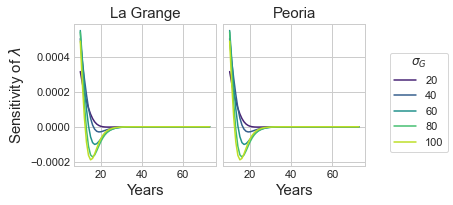

In [10]:
values = [20, 40, 60, 80, 100]
table = vonB_sigma_data
col = 'sd'
row = 0
name = '$\sigma_G$'

sens_a, sens_b = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, name, values, start_at=10, filename='growth_sd_sensitivity')

## $L_{\infty L}$

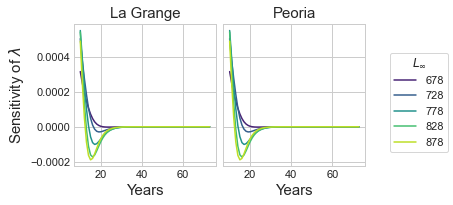

In [11]:
values = [678, 728, 778, 828, 878]
table = vonB_data
col = 'V1'
row = 0
name = r'$L_\infty$'

#sens_a, sens_b = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, name, values, start_at=10, filename='l_inf_sensitivity')

## K

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\network.py:171: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  transition_data_use['prob'] = transition_data_use.iloc[
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.vonB_data['pars'] = self.vonB_data[vonB_columns].mean(1)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this wil

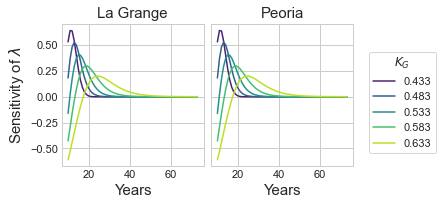

In [12]:
values = [0.433, 0.483, 0.533, 0.583, 0.633]
table = vonB_data
col = 'V1'
row = 1
name = r'$K_G$'

sens_a, sens_b = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, name, values, start_at=10, filename='k_sensitivity')

## Max Survival

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\network.py:171: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  transition_data_use['prob'] = transition_data_use.iloc[
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.vonB_data['pars'] = self.vonB_data[vonB_columns].mean(1)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this wil

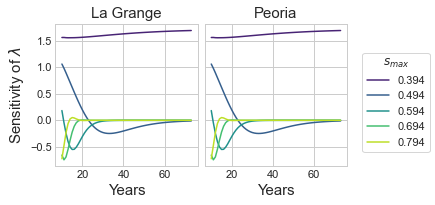

In [13]:
values = [0.394, 0.494, 0.594, 0.694, 0.794]
table = vonB_data
col = 'V1'
row = 2
name = r'$s_{max}$'

sens_a, sens_b = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, name, values, start_at=10, filename='max_surv_sensitivity')

## Survival $\alpha$

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\network.py:171: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  transition_data_use['prob'] = transition_data_use.iloc[
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.vonB_data['pars'] = self.vonB_data[vonB_columns].mean(1)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this wil

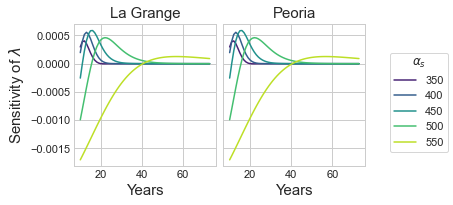

In [14]:
values = [350, 400, 450, 500, 550]
table = vonB_data
col = 'V1'
row = 3
name = r'$\alpha_s$'

sens_a, sens_b = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, name, values, start_at=10, filename='surv_alpha_sensitivity')

## Survival $\beta$

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\network.py:171: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  transition_data_use['prob'] = transition_data_use.iloc[
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.vonB_data['pars'] = self.vonB_data[vonB_columns].mean(1)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this wil

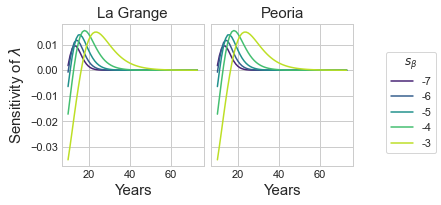

In [15]:
values = [-7, -6, -5, -4, -3]
table = vonB_data
col = 'V1'
row = 4
name = r'$s_\beta$'

sens_a, sens_b = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, name, values, start_at=10, filename='surv_beta_sensitivity')

## Min Survival

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\network.py:171: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  transition_data_use['prob'] = transition_data_use.iloc[
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.vonB_data['pars'] = self.vonB_data[vonB_columns].mean(1)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this wil

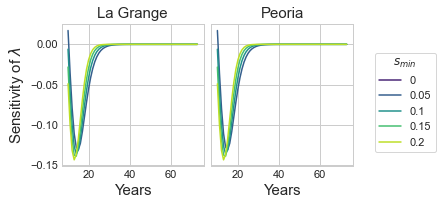

In [16]:
values = [0, 0.05, 0.1, 0.15, 0.2]
table = vonB_data
col = 'V1'
row = 5
name = r'$s_{min}$'

sens_a, sens_b = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, name, values, start_at=10, filename='min_surv_sensitivity')

## $g_m$

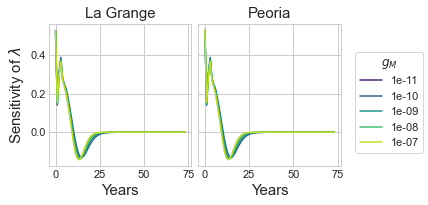

In [17]:
values = [0.00000000001, 0.0000000001, 0.000000001, 0.00000001, 0.0000001]
table = vonB_data
col = 'V1'
row = 6
name = r'$g_M$'

#sens_a, sens_b = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, name, values, start_at=0, filename='g_migration_sensitivity')

## $g_l$

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\network.py:171: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  transition_data_use['prob'] = transition_data_use.iloc[
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.vonB_data['pars'] = self.vonB_data[vonB_columns].mean(1)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this wil

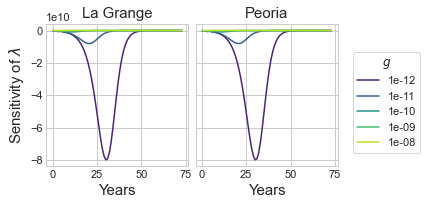

In [18]:
values = [10**(-12), 10**(-11), 10**(-10), 10**(-9), 10**(-8)]
table = vonB_data
col = 'V1'
row = 7
name = r'$g$'

sens_a, sens_b = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, name, values, start_at=0, filename='g_length_sensitivity')

## L -> P

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\network.py:171: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  transition_data_use['prob'] = transition_data_use.iloc[
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.vonB_data['pars'] = self.vonB_data[vonB_columns].mean(1)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this wil

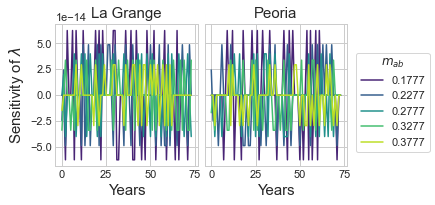

In [19]:
values = [0.1777, 0.2277, 0.2777, 0.3277, 0.3777]
table = transition_data
col = 'ab'
row = 0
name = r'$m_{ab}$'

sens_a, sens_b = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, name, values, start_at=0, filename='L_P_transition_sensitivity')

## P -> L

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\network.py:171: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  transition_data_use['prob'] = transition_data_use.iloc[
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.vonB_data['pars'] = self.vonB_data[vonB_columns].mean(1)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this wil

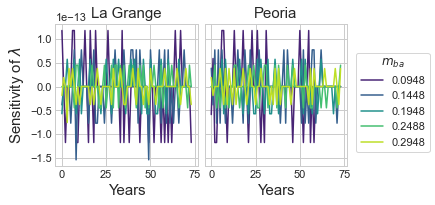

In [20]:
values = [0.0948, 0.1448, 0.1948, 0.2488, 0.2948]
table = transition_data
col = 'ba'
row = 0
name = r'$m_{ba}$'

sens_a, sens_b = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, name, values, start_at=0, filename='P_L_transition_sensitivity')

## Egg viability

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\network.py:171: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  transition_data_use['prob'] = transition_data_use.iloc[
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.vonB_data['pars'] = self.vonB_data[vonB_columns].mean(1)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this wil

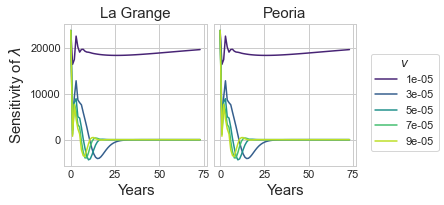

In [21]:
values = [0.00001, 0.00003, 0.00005, 0.00007, 0.00009]
table = network_data
col = 'egg_viability'
row = 0
name = r'$v$'

sens_a, sens_b = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, name, values, start_at=0, filename='egg_viability_sensitivity')

## $\alpha_e$

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\network.py:171: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  transition_data_use['prob'] = transition_data_use.iloc[
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.vonB_data['pars'] = self.vonB_data[vonB_columns].mean(1)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this wil

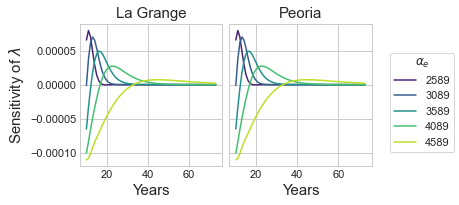

In [22]:
values = [2589, 3089, 3589, 4089, 4589]
table = node_data
col = 'egg_alpha'
row = [0, 1]
name = r'$\alpha_e$'

sens_a, sens_b = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, name, values, start_at=10, filename='egg_alpha_sensitivity')

## $\beta_e$

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\network.py:171: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  transition_data_use['prob'] = transition_data_use.iloc[
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.vonB_data['pars'] = self.vonB_data[vonB_columns].mean(1)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this wil

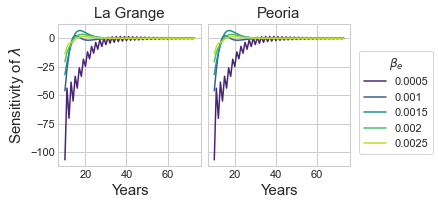

In [23]:
values = [0.0005, 0.0010, 0.0015, 0.0020, 0.0025]
table = node_data
col = 'egg_beta'
row = [0, 1]
name = r'$\beta_e$'

sens_a, sens_b = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, name, values, start_at=10, filename='egg_beta_sensitivity')

## $e_{max}$

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\network.py:171: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  transition_data_use['prob'] = transition_data_use.iloc[
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.vonB_data['pars'] = self.vonB_data[vonB_columns].mean(1)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this wil

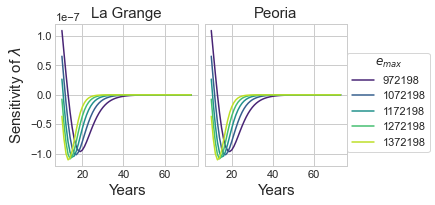

In [24]:
values = [972198, 1072198, 1172198, 1272198, 1372198]
table = node_data
col = 'max_recruit'
row = [0, 1]
name = r'$e_{max}$'

sens_a, sens_b = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, name, values, start_at=10, filename='egg_max_sensitivity')